In [1]:
import numpy as np

In [2]:

class FullyConnectedLayer(object):
    
    def __init__(self, num_inputs , layer_size , activation_function, derivated_activation_function = None):
        super().__init__()
        
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size
        
        
        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.H , self.out_put = None , None
        
        self.dLoss_dW , self.dLoss_db = None , None
        
        
    
    def forward( self, H_input ):
        z = np.dot(H_input , self.W ) + self.b
        self.out_put = self.activation_function(z)
        self.H =  H_input
        return self.out_put
    
    def backward(self, dLoss_dOut):
        dOut_dOin = self.derivated_activation_function(self.out_put)
        dLoss_dOin = (dLoss_dOut *  dOut_dOin)
        
        dOin_dW = self.H.T
        dOin_db = np.ones(dLoss_dOut.shape[0])
        dOin_dH = self.W.T
        
        
        self.dLoss_dW = np.dot(dOin_dW , dLoss_dOin )
        self.dLoss_db = np.dot(dOin_db, dLoss_dOin)
        
        dLoss_dH  = np.dot(dLoss_dOin , dOin_dH )
        
        return dLoss_dH
    
    def optimize(self, epsilon ):
        self.W = self.W  - epsilon*self.dLoss_dW
        self.b = self.b  - epsilon*self.dLoss_db
        
        

    

####  sigmoid activation function

In [3]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

#### derivated_sigmoid(y)

In [4]:
def derivated_sigmoid(y):
    return y*(1-y)

In [5]:
# L2 loss function 
def loss_L2(pred , target ):
    return np.sum(np.square(pred - target))/pred.shape[0]
    # divided by batch_size buz of take averge
    
    
def derivated_loss_L2(pred , target) :
    return 2*(pred - target)

In [6]:
def cross_entropy(pred , target ):
    y = np.multiply(np.log(pred) , target) + np.multiply(np.log(1-pred),(1-target))
    return -np.mean(y)



def derivated_cross_entropy(pred , target ):
    return (pred - target )/ (pred*(1-pred))
    

In [7]:
class SimpleNetwork:
    
    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32 , 16),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_L2, derivated_loss_function=derivated_loss_L2):
        super().__init__()
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        print("All layer node in FCN")
        print(layer_sizes)
        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function
        
    def forward(self , H ):
        for layer in self.layers:
            H = layer.forward(H)
        return H 
    
    
    def backward(self, dLoss_dout):
        for layer in reversed(self.layers):
            dLoss_dout = layer.backward(dLoss_dout)
        return dLoss_dout
    
    def optimize(self, alpa ):
        for layer in self.layers:
            layer.optimize(alpa)
            
    def predict( self, input_x ):
        estimations_value = self.forward(input_x)
        best_class = np.argmax(estimations_value)
        return best_class
    
    
    def evaluate_accuracy( self, X_val , y_val ):
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class  == y_val[i]:
                num_corrects += 1
        return num_corrects/len(X_val)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
      
        num_batches_per_epoch  = len(X_train)//batch_size
        do_validation = X_val is not None and y_val is not None
        losses, accuracies = [], []
        
        for i in range(num_epochs):
            epoch_loss  = 0
            for b in range(num_batches_per_epoch):
                
                batch_index_begin = b*batch_size
                batch_index_end =  batch_index_begin +  batch_size
                
                x = X_train[batch_index_begin : batch_index_end]
                targets = y_train[batch_index_begin : batch_index_end]
                
                #Optimize  on batch 
                predictions = y = self.forward(x)
                loss = self.loss_function(predictions, targets )
                
                dLoss_dOut = self.derivated_loss_function(predictions, targets)
                self.backward(dLoss_dOut)
                self.optimize(learning_rate)
                epoch_loss += loss
                
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
                
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(i, epoch_loss, accuracy * 100))
        return losses, accuracies
                
        


In [8]:
%matplotlib inline
# !pip install matplotlib  # Uncomment and run if matplotlib is not installed yet.
import matplotlib          # We use this package to visualize some data and results
import matplotlib.pyplot as plt
import mnist

np.random.seed(42)

In [9]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9

In [10]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


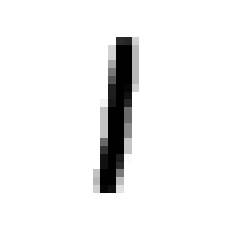

In [11]:
img_idx = np.random.randint( 0 , X_test.shape[0])
plt.imshow(X_test[img_idx] , cmap = matplotlib.cm.binary)
plt.axis('off')
plt.show()

In [12]:
print(y_test[img_idx])

1


In [13]:
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)

In [14]:
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


In [15]:
y_train = np.eye(num_classes)[y_train]

In [16]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [17]:
mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 32, 16])

All layer node in FCN
[784, 64, 32, 16, 10]


In [18]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 3.784788 | val accuracy = 9.78%


In [ ]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=100)